In [194]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="whitegrid")

In [195]:
dfJourneys = pd.read_csv('data/journeys.csv')
dfJourneys

,Trip ID Hash,Car ID Hash,Car Parking Address Postcode,Car Parking Address City,Trip Start At Local Time,Trip End At Local Time,Trip Created At Local Time,Trip Sum Trip Price
0,00010247034d28272cf5e1e16b43f52f,9ddac6a5fb0b3962db3b2f42fd31d3f9,94110,San Francisco,2017-11-14 22:15:00,2017-11-15 02:15:00,2017-11-14 20:32:59,$20.00
1,0001556e5d28e66b3318e89c094186c4,0f386ec90e0710ca143922520eaf8a3e,94117,San Francisco,2017-12-07 17:00:00,2017-12-08 04:00:00,2017-12-07 04:51:42,$55.00
2,000286e8771651e6983555c62558b57f,63e4509c686d891f5364c24339369460,94115,San Francisco,2017-03-23 10:00:00,2017-03-23 12:00:00,2017-03-23 08:49:48,$18.00
3,0003651ffd2f07a7226fd6b7c979fecb,c9fbe5bf8e406cd13bd33ff5411fa3e3,94103,San Francisco,2017-07-05 19:00:00,2017-07-06 01:45:00,2017-07-05 01:07:31,$33.75
4,000416e4334896da4a366e17ce42152e,48275fb73951c77021f9d820d15c5139,2118,Boston,2017-01-24 09:00:00,2017-01-24 11:30:00,2017-01-22 22:47:11,$21.25
...,...,...,...,...,...,...,...,...
56532,fff8beb7734d2565811983e5ab8bea35,25a09dbf6fbcc85cbb8ae48d311fbccf,20006,Washington,2017-11-05 12:15:00,2017-11-05 19:00:00,2017-11-04 06:46:56,$43.89
56533,fffb60627f2c2e408fef7d739543deee,d0b26f3508b4bb46f1f1b42708545df0,94108,San Francisco,2017-10-23 08:30:00,2017-10-23 18:30:00,2017-10-19 15:46:46,$55.19
56534,fffbade87b23f0ab0bd2b728d4e0f941,cf3e2d7ddc9071ee85355993ad661042,60611,Chicago,2017-12-16 20:45:00,2017-12-17 00:45:00,2017-12-05 06:30:48,$26.12
56535,fffd3b9e130841ba884e4fa880e44594,c687b40673df4c0fe842261a6d58b194,94114,San Francisco,2017-02-19 18:30:00,2017-02-19 19:45:00,2017-02-19 18:10:59,$10.62


In [196]:
dfJourneys['Trip Start At Local Time'] = pd.to_datetime(dfJourneys['Trip Start At Local Time'], format="%Y/%m/%d %H:%M:%S")
dfJourneys['Trip End At Local Time'] = pd.to_datetime(dfJourneys['Trip End At Local Time'], format="%Y/%m/%d %H:%M:%S")
dfJourneys['Trip Created At Local Time'] = pd.to_datetime(dfJourneys['Trip Created At Local Time'], format="%Y/%m/%d %H:%M:%S")

dfJourneys['Trip Sum Trip Price'] = dfJourneys['Trip Sum Trip Price'].astype(str)
dfJourneys['Trip Sum Trip Price'] = dfJourneys['Trip Sum Trip Price'].str.replace('$','')
dfJourneys['Trip Sum Trip Price'] = dfJourneys['Trip Sum Trip Price'].str.replace(',','')
dfJourneys['Trip Sum Trip Price'] = dfJourneys['Trip Sum Trip Price'].astype(float)

dfJourneys.rename(columns = { 'Car Parking Address City':'city'
                             , 'Trip Start At Local Time':'journeyStartTime'
                             , 'Trip End At Local Time':'journeyEndTime'
                             , 'Trip Created At Local Time':'journeyCreationTime'
                             , 'Trip Sum Trip Price':'priceInDollar'
                            }, inplace = True)

dfJourneys['journeyDurationInHour'] = (dfJourneys.journeyEndTime - dfJourneys.journeyStartTime) / pd.Timedelta(hours=1)
dfJourneys['journeyDurationInHour'] = dfJourneys['journeyDurationInHour'].apply(np.int64)

# derive this while prediction dataset
dfJourneys['preBookingDurationInHour'] = (dfJourneys.journeyStartTime - dfJourneys.journeyCreationTime) / pd.Timedelta(hours=1)
dfJourneys['preBookingDurationInHour'] = dfJourneys['preBookingDurationInHour'].apply(np.int64)

dfJourneys['journeyStartHr'] = dfJourneys['journeyStartTime'].dt.hour
dfJourneys['journeyStartWeekday'] = dfJourneys['journeyStartTime'].dt.weekday
dfJourneys['journeyStartMonth'] = dfJourneys['journeyStartTime'].dt.month

# Bifurcate dataset into weekday & weekend
def fn_is_weekend(row):
    if ((row['journeyStartWeekday'] == 5) | (row['journeyStartWeekday'] == 6)):
        return 1
    else:
        return 0
    
dfJourneys['isWeekend'] = dfJourneys.apply(lambda x: fn_is_weekend(x), axis=1)

# Bifurcate dataset into yearly quarters

def fn_get_year_quarters(row):
    if ((row['journeyStartMonth'] >= 0) & (row['journeyStartMonth'] <= 2)):
        return 1
    elif ((row['journeyStartMonth'] >= 3) & (row['journeyStartMonth'] <= 5)):
        return 2
    elif ((row['journeyStartMonth'] >= 6) & (row['journeyStartMonth'] <= 8)):
        return 3
    else:
        return 4

dfJourneys['yearQuarter'] = dfJourneys.apply(lambda x: fn_get_year_quarters(x), axis=1)

# Bifurcate dataset w.r.t. daily hours
'''
1 : 21 - 5  : nightHours
2 : 6 - 7   : morningNonPeakHours
3 : 8 - 13  : morningPeakHours
4 : 14 - 17 : eveningPeakHours
5 : 18 - 20 : eveningNonPeakHours
'''
def fn_get_peak_hours(row):
    if ((row['journeyStartHr'] >= 21) | (row['journeyStartHr'] <= 5)):
        return 'nightHours'
    elif ((row['journeyStartHr'] == 6) | (row['journeyStartHr'] == 7)):
        return 'morningNonPeakHours'
    elif ((row['journeyStartHr'] >= 8) & (row['journeyStartHr'] <= 13)):
        return 'morningPeakHours'
    elif ((row['journeyStartHr'] >= 14) & (row['journeyStartHr'] <= 17)):
        return 'eveningPeakHours'
    else:
        return 'eveningNonPeakHours'

dfJourneys['peakHours'] = dfJourneys.apply(lambda x: fn_get_peak_hours(x), axis=1)    

#dfJourneys.dtypes
dfJourneys

,Trip ID Hash,Car ID Hash,Car Parking Address Postcode,city,journeyStartTime,journeyEndTime,journeyCreationTime,priceInDollar,journeyDurationInHour,preBookingDurationInHour,journeyStartHr,journeyStartWeekday,journeyStartMonth,isWeekend,yearQuarter,peakHours
0,00010247034d28272cf5e1e16b43f52f,9ddac6a5fb0b3962db3b2f42fd31d3f9,94110,San Francisco,2017-11-14 22:15:00,2017-11-15 02:15:00,2017-11-14 20:32:59,20.00,4,1,22,1,11,0,4,nightHours
1,0001556e5d28e66b3318e89c094186c4,0f386ec90e0710ca143922520eaf8a3e,94117,San Francisco,2017-12-07 17:00:00,2017-12-08 04:00:00,2017-12-07 04:51:42,55.00,11,12,17,3,12,0,4,eveningPeakHours
2,000286e8771651e6983555c62558b57f,63e4509c686d891f5364c24339369460,94115,San Francisco,2017-03-23 10:00:00,2017-03-23 12:00:00,2017-03-23 08:49:48,18.00,2,1,10,3,3,0,2,morningPeakHours
3,0003651ffd2f07a7226fd6b7c979fecb,c9fbe5bf8e406cd13bd33ff5411fa3e3,94103,San Francisco,2017-07-05 19:00:00,2017-07-06 01:45:00,2017-07-05 01:07:31,33.75,6,17,19,2,7,0,3,eveningNonPeakHours
4,000416e4334896da4a366e17ce42152e,48275fb73951c77021f9d820d15c5139,2118,Boston,2017-01-24 09:00:00,2017-01-24 11:30:00,2017-01-22 22:47:11,21.25,2,34,9,1,1,0,1,morningPeakHours
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56532,fff8beb7734d2565811983e5ab8bea35,25a09dbf6fbcc85cbb8ae48d311fbccf,20006,Washington,2017-11-05 12:15:00,2017-11-05 19:00:00,2017-11-04 06:46:56,43.89,6,29,12,6,11,1,4,morningPeakHours
56533,fffb60627f2c2e408fef7d739543deee,d0b26f3508b4bb46f1f1b42708545df0,94108,San Francisco,2017-10-23 08:30:00,2017-10-23 18:30:00,2017-10-19 15:46:46,55.19,10,88,8,0,10,0,4,morningPeakHours
56534,fffbade87b23f0ab0bd2b728d4e0f941,cf3e2d7ddc9071ee85355993ad661042,60611,Chicago,2017-12-16 20:45:00,2017-12-17 00:45:00,2017-12-05 06:30:48,26.12,4,278,20,5,12,1,4,eveningNonPeakHours
56535,fffd3b9e130841ba884e4fa880e44594,c687b40673df4c0fe842261a6d58b194,94114,San Francisco,2017-02-19 18:30:00,2017-02-19 19:45:00,2017-02-19 18:10:59,10.62,1,0,18,6,2,1,1,eveningNonPeakHours


In [197]:
import numpy as np  
import seaborn as sns

Q1 = np.percentile(dfJourneys['priceInDollar'], 25, interpolation = 'midpoint')
Q2 = np.percentile(dfJourneys['priceInDollar'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(dfJourneys['priceInDollar'], 75, interpolation = 'midpoint')
print(Q1, Q2, Q3)

IQR = Q3 - Q1
print('Interquartile range is', IQR)

lowerLimit = Q1 - 1.5 * IQR
print('Lower limit is', lowerLimit)

upperLimit = Q3 + 1.5 * IQR
print('Upper limit is', upperLimit)

outlier =[]
for x in dfJourneys['priceInDollar']:
    if ((x> upperLimit) or (x<lowerLimit)):
         outlier.append(x)
print(' outlier in the dataset is', outlier)
len(outlier)

# dropping outliers records
dfJourneys.drop(dfJourneys[(dfJourneys['priceInDollar'] > upperLimit) | (dfJourneys['priceInDollar'] < lowerLimit)].index, inplace = True)

24.0 39.87 63.25
Interquartile range is 39.25
Lower limit is -34.875
Upper limit is 122.125
 outlier in the dataset is [517.5, 157.5, 126.25, 184.5, 133.17, 225.0, 232.5, 146.26, 234.0, 132.5, 270.0, 162.6, 238.5, 125.0, 136.12, 131.92, 130.68, 245.25, 159.37, 172.5, 150.0, 167.07, 140.0, 330.0, 168.0, 162.74, 160.0, 198.0, 154.0, 142.41, 272.5, 139.79, 335.61, 196.44, 450.0, 391.87, 322.5, 647.5, 450.0, 145.0, 137.5, 150.0, 175.0, 131.25, 140.0, 270.0, 165.75, 160.0, 150.0, 418.0, 147.0, 123.25, 255.0, 375.0, 137.5, 233.62, 336.16, 306.0, 139.06, 170.0, 150.0, 414.0, 465.0, 240.0, 231.83, 450.0, 130.0, 380.0, 170.0, 285.84, 176.0, 297.0, 325.0, 209.38, 342.13, 148.76, 334.37, 480.0, 128.0, 148.43, 180.0, 171.0, 144.88, 269.26, 215.0, 180.0, 137.5, 225.22, 135.0, 142.5, 166.5, 128.0, 178.75, 132.75, 360.0, 263.5, 124.0, 334.74, 220.0, 180.0, 180.0, 157.5, 225.0, 295.34, 133.0, 180.0, 135.0, 161.5, 292.12, 148.0, 142.5, 264.67, 408.0, 130.0, 190.0, 148.11, 195.0, 247.5, 242.5, 171.0, 17

In [199]:
dfJourneys

,Trip ID Hash,Car ID Hash,Car Parking Address Postcode,city,journeyStartTime,journeyEndTime,journeyCreationTime,priceInDollar,journeyDurationInHour,preBookingDurationInHour,journeyStartHr,journeyStartWeekday,journeyStartMonth,isWeekend,yearQuarter,peakHours
0,00010247034d28272cf5e1e16b43f52f,9ddac6a5fb0b3962db3b2f42fd31d3f9,94110,San Francisco,2017-11-14 22:15:00,2017-11-15 02:15:00,2017-11-14 20:32:59,20.00,4,1,22,1,11,0,4,nightHours
1,0001556e5d28e66b3318e89c094186c4,0f386ec90e0710ca143922520eaf8a3e,94117,San Francisco,2017-12-07 17:00:00,2017-12-08 04:00:00,2017-12-07 04:51:42,55.00,11,12,17,3,12,0,4,eveningPeakHours
2,000286e8771651e6983555c62558b57f,63e4509c686d891f5364c24339369460,94115,San Francisco,2017-03-23 10:00:00,2017-03-23 12:00:00,2017-03-23 08:49:48,18.00,2,1,10,3,3,0,2,morningPeakHours
3,0003651ffd2f07a7226fd6b7c979fecb,c9fbe5bf8e406cd13bd33ff5411fa3e3,94103,San Francisco,2017-07-05 19:00:00,2017-07-06 01:45:00,2017-07-05 01:07:31,33.75,6,17,19,2,7,0,3,eveningNonPeakHours
4,000416e4334896da4a366e17ce42152e,48275fb73951c77021f9d820d15c5139,2118,Boston,2017-01-24 09:00:00,2017-01-24 11:30:00,2017-01-22 22:47:11,21.25,2,34,9,1,1,0,1,morningPeakHours
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56532,fff8beb7734d2565811983e5ab8bea35,25a09dbf6fbcc85cbb8ae48d311fbccf,20006,Washington,2017-11-05 12:15:00,2017-11-05 19:00:00,2017-11-04 06:46:56,43.89,6,29,12,6,11,1,4,morningPeakHours
56533,fffb60627f2c2e408fef7d739543deee,d0b26f3508b4bb46f1f1b42708545df0,94108,San Francisco,2017-10-23 08:30:00,2017-10-23 18:30:00,2017-10-19 15:46:46,55.19,10,88,8,0,10,0,4,morningPeakHours
56534,fffbade87b23f0ab0bd2b728d4e0f941,cf3e2d7ddc9071ee85355993ad661042,60611,Chicago,2017-12-16 20:45:00,2017-12-17 00:45:00,2017-12-05 06:30:48,26.12,4,278,20,5,12,1,4,eveningNonPeakHours
56535,fffd3b9e130841ba884e4fa880e44594,c687b40673df4c0fe842261a6d58b194,94114,San Francisco,2017-02-19 18:30:00,2017-02-19 19:45:00,2017-02-19 18:10:59,10.62,1,0,18,6,2,1,1,eveningNonPeakHours


In [201]:
dfJourneys.describe()

,Car Parking Address Postcode,priceInDollar,journeyDurationInHour,preBookingDurationInHour,journeyStartHr,journeyStartWeekday,journeyStartMonth,isWeekend,yearQuarter
count,52864.000000,52864.000000,52864.000000,52864.000000,52864.000000,52864.000000,52864.000000,52864.000000,52864.000000
mean,78552.212413,42.018788,6.570558,14.245384,12.627232,3.326139,7.946277,0.364255,3.189694
std,30531.296835,24.843472,5.420342,35.972963,4.713401,1.995806,3.274488,0.481225,0.997621
min,2108.000000,3.030000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,94066.000000,22.500000,3.000000,0.000000,9.000000,2.000000,6.000000,0.000000,3.000000
50%,94110.000000,37.500000,5.000000,2.000000,12.000000,4.000000,9.000000,0.000000,4.000000
75%,94122.000000,56.635000,8.000000,15.000000,16.000000,5.000000,11.000000,1.000000,4.000000
max,94720.000000,122.110000,60.000000,671.000000,23.000000,6.000000,12.000000,1.000000,4.000000


Text(0.5, 1.0, 'City-wise trips during weekends and weekdays')

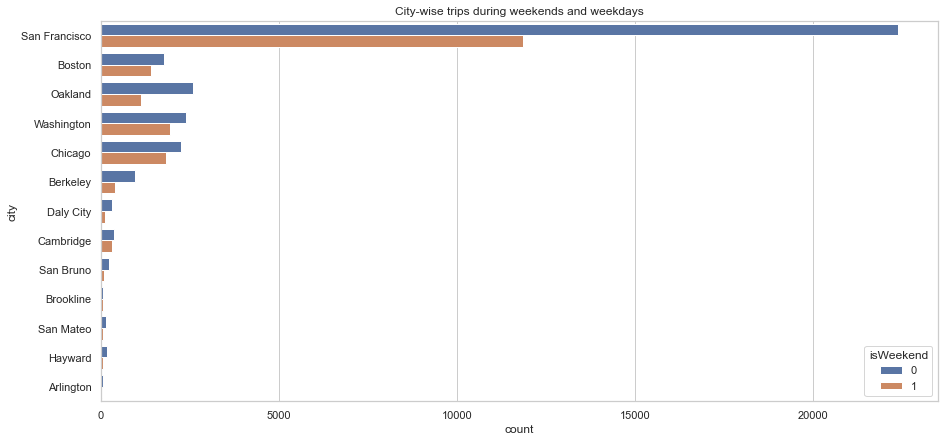

In [135]:
# city-wise trips count
plt.figure(figsize=(15,7))
cp=sns.countplot(y="city", hue = "isWeekend", data=dfJourneys)
cp.set_title('City-wise trips during weekends and weekdays')

In [58]:
#sns.catplot(x="journeyStartWeekday", y="priceInDollar", kind="swarm", data=dfJourneys)

In [57]:
#sns.catplot(x="priceInDollar", y="journeyStartWeekday", hue="peakHours", kind="swarm", data=dfJourneys)

Text(0.5, 1.0, 'Hour-wise break for each Weekday')

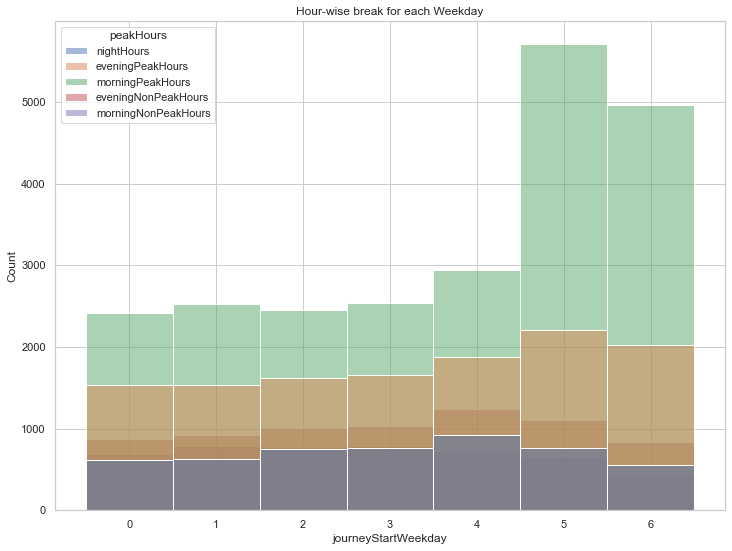

In [136]:
plt.figure(figsize=(12,9))
cp=sns.histplot(data = dfJourneys, x="journeyStartWeekday", hue = "peakHours", binwidth = 1, discrete=True)
cp.set_title('Hour-wise break for each Weekday')

Text(0.5, 1.0, 'No. of trips as per daily Hours')

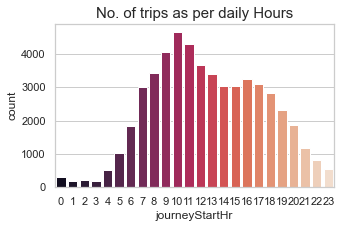

In [137]:
plt.figure(figsize=(5,3))
cp=sns.countplot(x="journeyStartHr", data=dfJourneys, palette='rocket')
cp.set_title("No. of trips as per daily Hours", fontsize = 15)

Text(0.5, 1.0, 'Total price as per daily Hours')

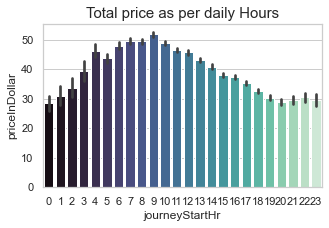

In [138]:
plt.figure(figsize=(5,3))
cp = sns.barplot(x="journeyStartHr",y='priceInDollar', data=dfJourneys, palette='mako')
cp.set_title("Total price as per daily Hours", fontsize = 15)

Text(0.5, 1.0, 'No. of trips basis week days')

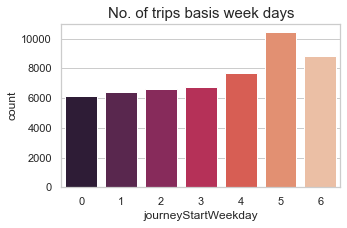

In [139]:
plt.figure(figsize=(5,3))
cp=sns.countplot(x="journeyStartWeekday", data=dfJourneys, palette='rocket')
cp.set_title("No. of trips basis week days", fontsize = 15)

Text(0.5, 1.0, 'Total price basis week days')

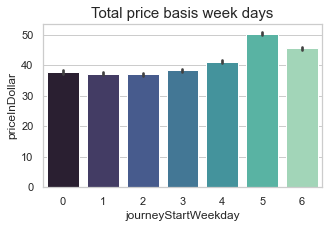

In [140]:
plt.figure(figsize=(5,3))
cp = sns.barplot(x="journeyStartWeekday",y='priceInDollar', data=dfJourneys, palette='mako')
cp.set_title("Total price basis week days", fontsize = 15)

Text(0.5, 1.0, 'No. of trips per yearly quarter')

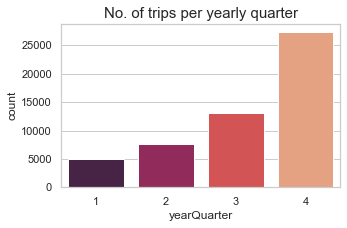

In [141]:
plt.figure(figsize=(5,3))
cp = sns.countplot(x="yearQuarter", data=dfJourneys, palette='rocket')
cp.set_title("No. of trips per yearly quarter", fontsize = 15)

Text(0.5, 1.0, 'Total price per yearly quarter')

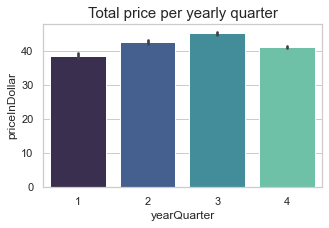

In [142]:
plt.figure(figsize=(5,3))
cp = sns.barplot(x="yearQuarter",y='priceInDollar', data=dfJourneys, palette='mako')
cp.set_title("Total price per yearly quarter", fontsize = 15)

Text(0.5, 1.0, 'Relation between journey duration and price')

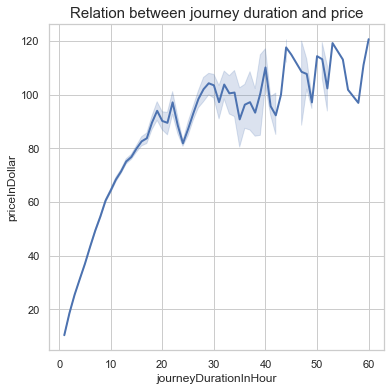

In [159]:
plt.figure(figsize=(6,6))
cp = sns.lineplot(y='priceInDollar', x='journeyDurationInHour', data=dfJourneys, marker='', palette='mako', linewidth=2)
cp.set_title('Relation between journey duration and price', fontsize = 15)

Text(0.5, 1.0, 'Relation between booking duration and price')

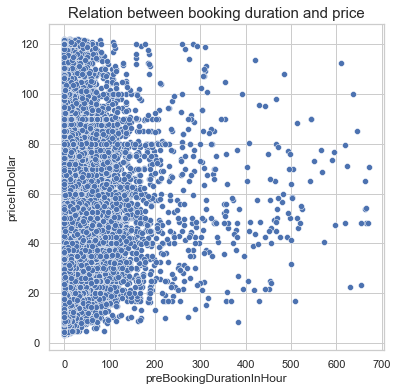

In [162]:
plt.figure(figsize=(6,6))
cp = sns.scatterplot( y='priceInDollar', x='preBookingDurationInHour', data=dfJourneys)
cp.set_title('Relation between booking duration and price', fontsize = 15)

**The below code was used to derive variables - utilizationInHour & availabilityInHour & stored data in a file**
**The file - dfJourneysSanFranciscoDerived contains data for only San Francisco**


def get_car_availablity(row):
    df = dfUtilizationSanFrancisco.loc[(dfUtilizationSanFrancisco.carId == row['carId']) \
                 & (dfUtilizationSanFrancisco.hourlyTimestamp >= row['localTripStartTime']) \
                 & (dfUtilizationSanFrancisco.hourlyTimestamp <= row['localTripEndTime'])]
    return df.aggregate({"availableTimeInMinutes":['sum']}).iloc[0] / 60

def get_car_utilization(row):
    df = dfUtilizationSanFrancisco.loc[(dfUtilizationSanFrancisco.carId == row['carId']) \
                 & (dfUtilizationSanFrancisco.hourlyTimestamp >= row['localTripStartTime']) \
                 & (dfUtilizationSanFrancisco.hourlyTimestamp <= row['localTripEndTime'])]
    return df.aggregate({"utilizationTimeInMinutes":['sum']}).iloc[0] / 60

dfJourneysSanFrancisco['utilizationInHour'] = dfJourneysSanFrancisco.apply(lambda x: get_car_utilization(x), axis=1)
dfJourneysSanFrancisco['availabilityInHour'] = dfJourneysSanFrancisco.apply(lambda x: get_car_availablity(x), axis=1)

dfJourneysSanFrancisco.to_csv (r'dfJourneysSanFranciscoDerived.csv', index = False, header=True)

In [165]:
dfJourneysSanFranciscoDerived = pd.read_csv('dfJourneysSanFranciscoDerived.csv')
dfJourneysSanFranciscoDerived

,tripId,carId,carParkingZipCode,carParkingCity,localTripStartTime,localTripEndTime,localTripCreationTime,priceInDollar,TripStartHour,TripStartDay,TripStartMonth,TripStartWeekDay,tripDurationInHour,preBookingDurationInHour,utilizationInHour,availabilityInHour
0,00010247034d28272cf5e1e16b43f52f,9ddac6a5fb0b3962db3b2f42fd31d3f9,94110,San Francisco,2017-11-14 22:15:00,2017-11-15 02:15:00,2017-11-14 20:32:59,20.00,22,14,11,1,4,1,3.75,4.0
1,0001556e5d28e66b3318e89c094186c4,0f386ec90e0710ca143922520eaf8a3e,94117,San Francisco,2017-12-07 17:00:00,2017-12-08 04:00:00,2017-12-07 04:51:42,55.00,17,7,12,3,11,12,11.50,12.0
2,000286e8771651e6983555c62558b57f,63e4509c686d891f5364c24339369460,94115,San Francisco,2017-03-23 10:00:00,2017-03-23 12:00:00,2017-03-23 08:49:48,18.00,10,23,3,3,2,1,2.50,3.0
3,0003651ffd2f07a7226fd6b7c979fecb,c9fbe5bf8e406cd13bd33ff5411fa3e3,94103,San Francisco,2017-07-05 19:00:00,2017-07-06 01:45:00,2017-07-05 01:07:31,33.75,19,5,7,2,6,17,7.00,7.0
4,00046a5e37fee728d9b1c0840741f944,812d1f2214d3fe7f9624f03b1a78cb61,94123,San Francisco,2017-12-14 13:15:00,2017-12-14 14:45:00,2017-12-14 13:08:08,14.11,13,14,12,3,1,0,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36149,fff0fc15ad79ab5e93714bafa5a6dc20,26b26593b7a0f7a80b0a7a0747882a6d,94110,San Francisco,2017-02-25 14:00:00,2017-02-25 16:00:00,2017-02-25 13:41:53,17.50,14,25,2,5,2,0,2.50,3.0
36150,fff8ae03853b573d81782ba277413dee,5fa4b685ba407cae4ea84b6a0fa80a0e,94103,San Francisco,2017-05-18 13:15:00,2017-05-18 22:30:00,2017-05-17 21:51:14,46.25,13,18,5,3,9,15,9.00,9.0
36151,fffb60627f2c2e408fef7d739543deee,d0b26f3508b4bb46f1f1b42708545df0,94108,San Francisco,2017-10-23 08:30:00,2017-10-23 18:30:00,2017-10-19 15:46:46,55.19,8,23,10,0,10,88,10.00,10.0
36152,fffd3b9e130841ba884e4fa880e44594,c687b40673df4c0fe842261a6d58b194,94114,San Francisco,2017-02-19 18:30:00,2017-02-19 19:45:00,2017-02-19 18:10:59,10.62,18,19,2,6,1,0,1.00,1.0


Text(0.5, 1.0, 'Relation between journey duration and price')

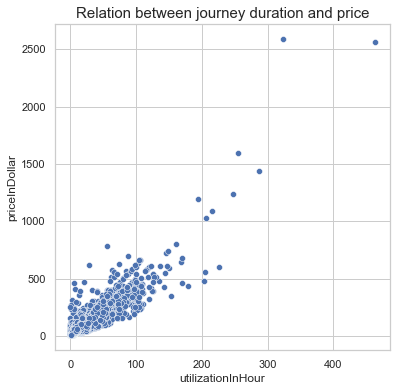

In [171]:
plt.figure(figsize=(6,6))
cp = sns.scatterplot( y='priceInDollar', x='utilizationInHour', data=dfJourneysSanFranciscoDerived)
cp.set_title('Relation between journey duration and price', fontsize = 15)

Text(0.5, 1.0, 'Relation between journey duration and price')

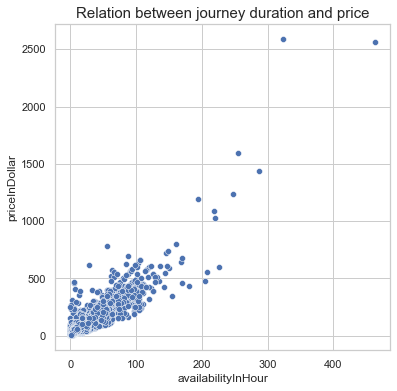

In [172]:
plt.figure(figsize=(6,6))
cp = sns.scatterplot( y='priceInDollar', x='availabilityInHour', data=dfJourneysSanFranciscoDerived)
cp.set_title('Relation between journey duration and price', fontsize = 15)

In [191]:
#plt.plot( 'TripStartMonth', 'utilizationInHour', data=dfJourneysSanFranciscoDerived, marker='', color='purple', linewidth=2)
#plt.plot( 'TripStartMonth', 'availabilityInHour', data=dfJourneysSanFranciscoDerived, marker='', color='blue', linewidth=2)

'''
%utilization: (utilized/available)*100
'''

df = dfJourneysSanFranciscoDerived[['priceInDollar','availabilityInHour','utilizationInHour']]
df['percentUtilization'] = round(((df['utilizationInHour'] / df['availabilityInHour']) * 100),2)
#sns.pairplot(df)

<ipython-input-191-b1359b4f0fd6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percentUtilization'] = round(((df['utilizationInHour'] / df['availabilityInHour']) * 100),2)


In [192]:
df

,priceInDollar,availabilityInHour,utilizationInHour,percentUtilization
0,20.00,4.0,3.75,93.75
1,55.00,12.0,11.50,95.83
2,18.00,3.0,2.50,83.33
3,33.75,7.0,7.00,100.00
4,14.11,1.0,1.00,100.00
...,...,...,...,...
36149,17.50,3.0,2.50,83.33
36150,46.25,9.0,9.00,100.00
36151,55.19,10.0,10.00,100.00
36152,10.62,1.0,1.00,100.00


Text(0.5, 1.0, 'Relation between journey duration and price')

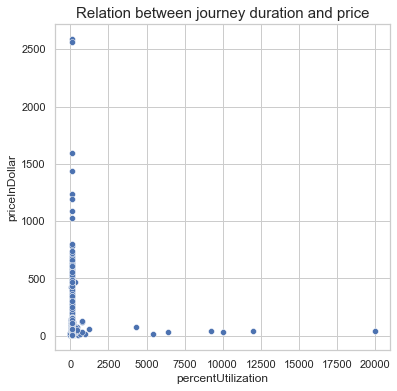

In [193]:
plt.figure(figsize=(6,6))
cp = sns.scatterplot( y='priceInDollar', x='percentUtilization', data=df)
cp.set_title('Relation between journey duration and price', fontsize = 15)